## Pràctica 8


In [1]:
%pip install simpy

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
from IPython.display import Math, display
import sympy as sp
from sympy.physics.units.systems import SI
from sympy.physics.units import meter, second, liter, hour, degree, convert_to
from sympy import sin, cos, pi, Abs
import simpy

sp.init_printing()

def show(*args):
    out = ""
    for arg in args:
        if isinstance(arg, (sp.Expr, sp.Eq)):
            arg = sp.latex(arg)
        else:
            arg = str(arg)
        out += arg
    display(Math(out))

qq = "\quad "

### Exercici 1
- A una cabina experimental es genera ozó, que és un gas tòxic que volem extreure.
- Hem modelitzat l'extracció d'ozó de la següent manera:
$$x'  = -x \cdot Q/V + O \cdot R $$

on $x$ representa la concentració del gas, $Q$ representa el flux d'extracció d'aire, $V$ és el volum de l'habitació, $O$ és la concentració d'oxigen a l'aire i $R$ és el ritme de generació d'ozó.

Els valors mesurats dels paràmetres són els següents:
- La generació d'ozó es produeix a un ritme d'una molècula d'ozó per cada $(3.7 \pm 0.1) \times 10^9$ molècules d'oxigen per segon.
- La concentració d'oxigen a l'aire és de $20.9476 \pm 0.0005 \%$
- La cabina experimental té un volum de $125.4 \pm 0.8 \, m^3$


#### Dades
- Per validar el model hem fet unes proves irradiant un volum d'aire amb un extractor.
    - Volum d'aire $1.0000 \pm 1\times10^{-4} m^3$
    - Cabal d'aire de l'extractor $1.0 \pm 0.1 l/s$
    - La precisió de les mesures de concentració és de $1\times10^{-3}$ ppm

Index(['t (s)', 'Concentració (ppm)'], dtype='object')


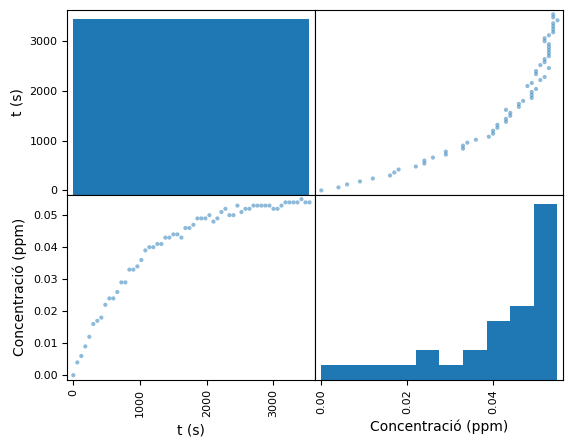

In [2]:
# Dades
data = pd.read_csv("https://raw.githubusercontent.com/gjover/modelitzacio/refs/heads/main/data/ozo.csv")
print(data.columns)
l = pd.plotting.scatter_matrix(data[data.columns])

- Fes la validació del model i una anàlisi crítica considerant que l'ozó és tòxic a concentracions de 5 ppm i el seu nivell de seguretat és de 0.1 ppm

#### Definció simbòlica del model
Per començar, anem a definir de manera simbòlica el model i trobar una expressió per la concentració de la forma $x(t)$

In [4]:
from sympy.abc import t,Q,V,O,R

# Creem la x com a funció del temps
x = sp.Function('x')(t)

# Diferencial d'x respecte al temps
dx = sp.diff(x,t)

# Definim la equació diferencial que se'ns dona a l'enuncialt
fx = -x*Q/V+O*R
eq = sp.Eq(dx, fx)

# Definim la condició inicial
ics = {x.subs(t, 0): 0}

# Resolem l'equació diferencial, per a "x", usant les condicions inicials
sol = sp.dsolve(eq, x, ics=ics)
show("solution:  ", sol)

ppm = 1e6 # ppm, parts per milió, per a convertir la concentració a ppm
xt = sol.rhs * ppm # El valor x en funció del temps t
show("function (ppm):",xt)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

#### Avaluació del model amb les dades experimentals
Un cop tenim una expressió per la concentració $x(t)$ anem a estudiar la seva evolució temporal i comparar-la amb la de les dades experimentals de la cabina.

In [5]:
# Defimim el valor de les variables que se'ns dona a l'enunciat
valors = {Q: 1e-3,
          V: 1.0,
          O: 0.209476,
          R: 1/(3.7*1e9)}

xt_subs = xt.subs(valors)
xt_subs

                                         -0.001⋅t
0.0566151351351351 - 0.0566151351351351⋅ℯ        

Avaluem al llarg del temps i grafiquem la comparació

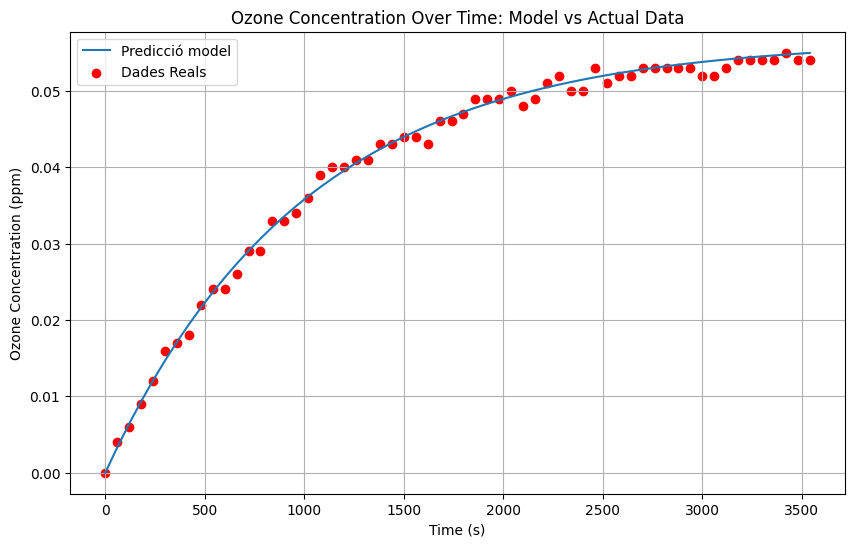

In [6]:
# Lambdify indicant que donarem valors numèrics a les variables, i indiquem que volem que ens quedi en funció de t, per tant substituïm per diferents valors de t
fxt = sp.lambdify(t,xt_subs)

# Obtenim els temps de la taula de dades
times = data['t (s)']

model_pred = fxt(times) # Obtenim les prediccions del model

# Graficació
plt.figure(figsize=(10, 6))
plt.plot(times, model_pred, label='Predicció model')
plt.scatter(times, data['Concentració (ppm)'], color='red', label='Dades Reals')
plt.xlabel('Time (s)')
plt.ylabel('Ozone Concentration (ppm)')
plt.title('Ozone Concentration Over Time: Model vs Actual Data')
plt.legend()
plt.grid(True)

Observem un bon comportament però cal validar aquest model en termes de incertesa i discrepància.
#### Discrepància del model
Abans de res, anem a veure la discrepància del model, és a dir, la diferència entre els valors predits i els valors reals.

Mean discrepancy: 0.00027158948741160227


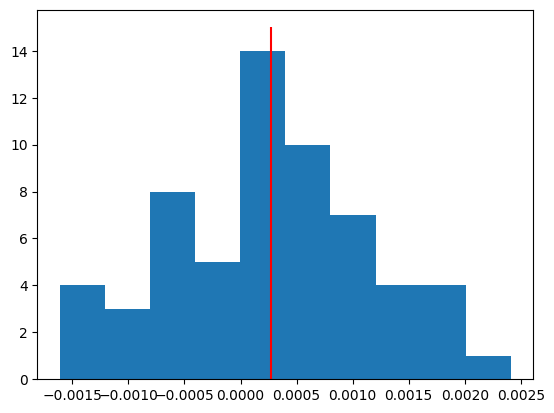

In [7]:
D = data['Concentració (ppm)']
E = model_pred - D
E_mean = np.mean(E)
plt.hist(E)
plt.vlines(E_mean, color='red', label='Mean Discrepancy', ymin=0, ymax=15)
print("Mean discrepancy:", E_mean)

Pel que fa a la incertesa, calcularem la incertesa relativa del model tenint en compte que $u_r^2=\sum (c_{x_i}u_{r_{x_i}})^2$, on $c_{x_i}$ és el coeficient de incertesa associat a cada variable i es calcula com $c_{x_i}=\frac{x_i}{f}\frac{\delta f}{\delta x_i}$. Anem a fer-ho

In [8]:
coef_Q= (Q/xt) * sp.diff(xt, Q)
coef_V= (V/xt) * sp.diff(xt, V)
coef_O= (O/xt) * sp.diff(xt, O)
coef_R= (R/xt) * sp.diff(xt, R)

coef_Q, coef_V, coef_O, coef_R

⎛  ⎛                 -Q⋅t                                       -Q⋅t ⎞         ↪
⎜  ⎜                 ─────                                      ─────⎟    ⎛    ↪
⎜  ⎜                   V                                          V  ⎟    ⎜    ↪
⎜  ⎜1000000.0⋅O⋅R⋅t⋅ℯ        1000000.0⋅O⋅R⋅V   1000000.0⋅O⋅R⋅V⋅ℯ     ⎟    ⎜    ↪
⎜Q⋅⎜────────────────────── - ─────────────── + ──────────────────────⎟    ⎜  1 ↪
⎜  ⎜          Q                     2                     2          ⎟  V⋅⎜- ─ ↪
⎜  ⎝                               Q                     Q           ⎠    ⎝    ↪
⎜─────────────────────────────────────────────────────────────────────, ────── ↪
⎜                                                 -Q⋅t                         ↪
⎜                                                 ─────                        ↪
⎜                                                   V                          ↪
⎜              1000000.0⋅O⋅R⋅V   1000000.0⋅O⋅R⋅V⋅ℯ                             ↪
⎜              ─────────────

In [9]:
urel_Q = 1e-4/valors[Q]
urel_V = 1e-4/valors[V]
urel_O = 1e-6/valors[O]
urel_R = 0.1/(3.7**2*1e9)/valors[R]

print(urel_Q, urel_V, urel_O, urel_R)

0.1 0.0001 4.773816570872081e-06 0.027027027027027025


In [10]:
Cur_Q = coef_Q * urel_Q
Cur_V = coef_V * urel_V
Cur_O = coef_O * urel_O
Cur_R = coef_R * urel_R
urXt2 = Cur_Q**2 + Cur_V**2 + Cur_O**2 + Cur_R**2

show("urXt^2_C=", urXt2)

<IPython.core.display.Math object>

Anem a calcular el valor d'aquesta incertesa relativa paramètrica al llarg del temps substituint les dades del paràmetres

In [11]:
u_param2 = urXt2.subs(valors)
u_param2 = sp.lambdify(t,u_param2)
u_param2 = u_param2(times)

Per calcular la incertesa total del model hi hem de sumar la associada a les dades. Tenim el seu valor en incertesa absoluta, de manera que primer hem de convertir $u_{param}$ de relativa a absoluta i sumarli quadràticament la de les dades i fer l'arrel

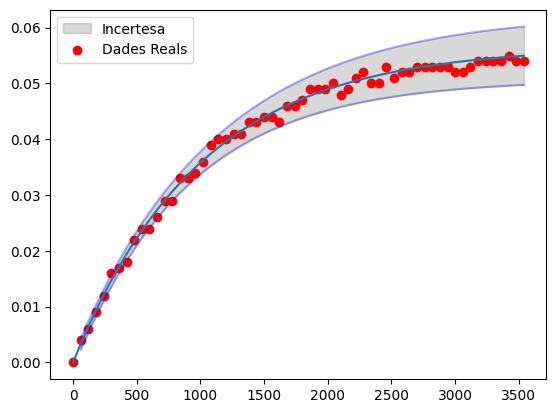

In [12]:
u_dades_abs = 1e-3
u_param_abs = np.sqrt(u_param2)*model_pred
uV = np.sqrt(u_param_abs**2+u_dades_abs**2)

plt.plot(times,model_pred+uV,color='blue',alpha=0.3)
plt.plot(times,model_pred)
plt.plot(times,model_pred-uV,color='blue',alpha=0.3)
plt.fill_between(times,
                 model_pred - uV,
                 model_pred + uV,
                 color='gray', alpha=0.3, label='Incertesa')
plt.scatter(times, D, color='red', label='Dades Reals')
plt.legend()
plt.show()

Anem a calcular el % de passos valids

In [13]:
# Limits inferiors i superiors
lower_bound = model_pred - uV
upper_bound = model_pred + uV

within_interval = (D >= lower_bound) & (D <= upper_bound)

percent_within_interval = within_interval.sum() / len(D) * 100
print(f"{percent_within_interval:.2f}% de las prediccions estan fins la franja d'incertesa del model")

93.33% de las prediccions estan fins la franja d'incertesa del model


Aquest % de passos vàlids ens permet dir que el nostre model funciona correctament. Anem a aplicar-lo a les dades d'interès per extreure conclusions de l'evolució temporal del nivell de concentració d'ozó

In [14]:
valors[V] = 125
xt_subs = xt.subs(valors)
fxt = sp.lambdify(t,xt_subs)
times_final = np.linspace(0, 1000000, 200)
model_pred_final = fxt(times_final)

urel_V = 0.8/valors[V]
Cur_V = coef_V * urel_V
urXt2 = Cur_Q**2 + Cur_V**2 + Cur_O**2 + Cur_R**2

show("urXt^2_C=", urXt2)

<IPython.core.display.Math object>

<lambdifygenerated-4>:2: RuntimeWarning: invalid value encountered in divide
  return 0.000730460212708974 + 0.64*(-8.0e-6*t*exp(-8.0e-6*t) + 1 - exp(-8.0e-6*t))**2/(125 - 125*exp(-8.0e-6*t))**2 + 156.25*(8.0e-6*t*exp(-8.0e-6*t) - 1 + exp(-8.0e-6*t))**2/(125 - 125*exp(-8.0e-6*t))**2


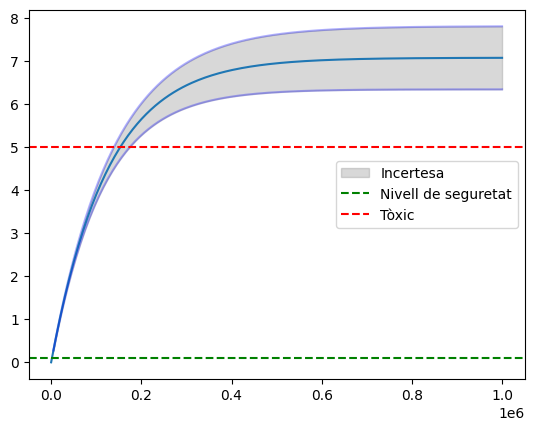

In [15]:
u_param2 = urXt2.subs(valors)
u_param2_lambd = sp.lambdify(t,u_param2)
u_param2_vals = u_param2_lambd(times_final)

# No comparem amb dades experimentals, de manera que no cal tenir en compte la seva incertesa
uV_final = np.sqrt(u_param2_vals)*model_pred_final

plt.plot(times_final,model_pred_final+uV_final,color='blue',alpha=0.3)
plt.plot(times_final,model_pred_final)
plt.plot(times_final,model_pred_final-uV_final,color='blue',alpha=0.3)
plt.fill_between(times_final,
                 model_pred_final - uV_final,
                 model_pred_final + uV_final,
                 color='gray', alpha=0.3, label='Incertesa')
plt.axhline(y=0.1, color='green', linestyle='--', label='Nivell de seguretat')
plt.axhline(y=5, color='red', linestyle='--', label='Tòxic')
plt.legend()
plt.show()

Observem que al llarg del temps es superen tots dos valors. Anem a trobar els instants on això passa, tant pel valor predit pel model com les cotes inferiors i superiors d'incertesa

In [16]:
xt_subs

                                     -8.0e-6⋅t
7.07689189189189 - 7.07689189189189⋅ℯ         

In [17]:
lower_bound = xt_subs - sp.sqrt(u_param2)
upper_bound = xt_subs + sp.sqrt(u_param2)

# Per 0.1
b01 = sp.nsolve(sp.Eq(lower_bound, 0.1), t, 1000)
a01 = sp.nsolve(sp.Eq(upper_bound, 0.1), t, 1000)
m01 = sp.nsolve(sp.Eq(xt_subs, 0.1), t, 1000)
print("Temps per 0.1 ppm", b01, m01, a01)

Temps per 0.1 ppm 2264.34705415991 1778.91038594966 1295.53315833345


In [18]:
# Per 5
b5 = sp.nsolve(sp.Eq(lower_bound, 5), t, 15000)
a5 = sp.nsolve(sp.Eq(upper_bound, 5), t, 15000)
m5 = sp.nsolve(sp.Eq(xt_subs, 5), t, 15000)
print("Temps per 5 ppm", b5, m5, a5)

Temps per 5 ppm 156714.886920075 153245.289947781 149954.377429097


#### EXTRA: RESOLUCIÓ NUMÈRICA DE LA EDO

In [ ]:
# si s'hagues de resoldre numericament la integral i no es pogues fer amb simpy
from scipy.integrate import odeint

df = data.copy()

Q_val, Q_err = 1.0e-3, 0.1e-3
V_val, V_err = 1.000, 1e-4
O_val, O_err = 20.9476 / 100, 0.0005 / 100
R_ratio_val, R_ratio_err = 1 / (3.7e9), 0.1e9 / (3.7e9)**2


k = Q_val / V_val
OR = O_val * R_ratio_val

def model(x,t):
    return -k * x + OR

x0 = 0.0

times = df['t (s)'].values
# Resolvemos la ecuación diferencial
x_model = odeint(model, x0, times).flatten()
x_model

array([0.00000000e+00, 3.29859584e-09, 6.40478659e-09, 9.32992414e-09,
       1.20862296e-08, 1.47033410e-08, 1.71898604e-08, 1.95457880e-08,
       2.17711236e-08, 2.38658674e-08, 2.58300193e-08, 2.76635792e-08,
       2.93665473e-08, 3.09389235e-08, 3.23977724e-08, 3.37842020e-08,
       3.51000227e-08, 3.63452346e-08, 3.75198376e-08, 3.86238317e-08,
       3.96572169e-08, 4.06199932e-08, 4.15121607e-08, 4.23342396e-08,
       4.31090775e-08, 4.38489086e-08, 4.45537329e-08, 4.52235505e-08,
       4.58583613e-08, 4.64581654e-08, 4.70229628e-08, 4.75527533e-08,
       4.80475372e-08, 4.85099507e-08, 4.89513286e-08, 4.93729690e-08,
       4.97748721e-08, 5.01570377e-08, 5.05194660e-08, 5.08621568e-08,
       5.11851101e-08, 5.14883261e-08, 5.17718047e-08, 5.20394127e-08,
       5.22949509e-08, 5.25384194e-08, 5.27698181e-08, 5.29891470e-08,
       5.31964061e-08, 5.33915955e-08, 5.35747151e-08, 5.37457649e-08,
       5.39051836e-08, 5.40566529e-08, 5.42010028e-08, 5.43382332e-08,
      

In [ ]:
"""
def solve_model(Q, V, R, O, times):
    def model(x, t):
        return -x * Q / V + O * R
    x0 = 0
    sol = odeint(model, x0, times)
    return sol.flatten()

# Valores nominales
Q = 1e-3
V = 1.0
O = 20.9476 / 100
R = 1 / (3.7e9)
times = np.linspace(0, 3500, 60)

# Solución base
x_nom = solve_model(Q, V, R, O, times)

# Aproximar derivadas parciales numéricamente
delta_q = 1e-5
x_plus_q = solve_model(Q + delta_q, V, R, O, times)
dx_dq = (x_plus_q - x_nom) / delta_q

# Idem para V, R, O
...

# Incertidumbres individuales
u_q = 0.1e-3
...

# Incertidumbre total propagada
U_x = np.sqrt((dx_dq * u_q)**2 + ... )
"""

#### EXTRA: INTERVAL

Si l'enunciat dona 5 +- 0.1 ppm

Notem que l'incertesa evoluciona i s'estabilitza al voltant de $0.1$, $10$%.

L'enunciat ens diu: *l'ozó és tòxic a concentracions de 5 ppm i el seu nivell de seguretat és de 0.1 ppm*. Això ens està demanant tenir una incertesa relativa sobre $x(t)$ del $\frac{0.1 ppm}{5 ppm} = 0.02$, $2$%.

La incertesa estàndard relativa representa una desviació estàndard: $\sigma = \frac{u(x)}{x}$

Hem de trobar un nivell de confiança del 95% en quin interval es pot trobar la incertesa de la concentració d'ozó. Per passar la desviació estàndard a un interval de confiança del 95%, cal multiplicar pel factor de cobertura estadística, aprozimem que $z(95\%) = 2$

Per tant, busquem que: $x \pm 2u(x) = 5 \pm 0.1$ ppm
- $2\frac{u(x)}{x} \le 0.02 \to \frac{u(x)}{x} \le 0.01$

#### Nivell de confiança per error del 5%

In [ ]:
t=0.05/ur
l,h = stats.t.cdf([-t,t], 1000)
CL = h-l
CL

### Exercici 2

Tenim un taller en el qual hi ha 5 màquines idèntiques que processen tasques que arriben de forma aleatòria cada 12 minuts de mitjana.
Les tasques s’assignen a qualsevol màquina que estigui lliure, o fan cua esperant que hi hagi alguna màquina lliure.
El temps necessari per completar una tasca també és aleatori, però de mitjana es triga una hora per a totes les tasques i màquines.

Al taller hi treballen 3 operaris, que tenen dues feines principals:

- Preparar les màquines perquè inicien la tasca que ha arribat.

- Reparar una màquina que ha fallat.

La preparació de la tasca necessita un temps aleatori, però que de mitjana és de 20 minuts.
La reparació necessita dos operaris i un temps aleatori, que de mitjana és de mitja hora.
Quan ha finalitzat una tasca, el 20% dels cops cal reparar la màquina.

- Fes 10 simulacions d'una setmana i calcula la llargària mitjana de la cua de tasques.

- Què faries per reduir la cua de tasques i per què?


In [19]:
def processar(enviroment,log,maquines,treballadors):
    with maquines.request() as maq:
        log.append({
            "temps": enviroment.now,
            "cua_maquines": len(maquines.queue)
        })

        yield maq
        with treballadors.request() as tr:
            yield tr
            temps = np.random.exponential(scale=20)
            yield enviroment.timeout(temps)

        temps = np.random.exponential(scale=60)
        yield enviroment.timeout(temps)

        if np.random.rand() < 0.2:
            with treballadors.request() as tr1, treballadors.request() as tr2:
                yield tr1 & tr2
                temps = np.random.exponential(scale=30)
                yield enviroment.timeout(temps)

In [20]:
def arribades(env, logs,maquines,treballadors):
    while True:
        temps = np.random.exponential(12)
        yield env.timeout(temps)
        env.process(processar(env, logs, maquines, treballadors))

In [21]:
def simulacio(num_maquines, num_treballadors):
    env = simpy.Environment()
    logs = []
    maquines = simpy.Resource(env, capacity=num_maquines)
    treballadors = simpy.Resource(env, capacity=num_treballadors)
    env.process(arribades(env, logs, maquines, treballadors))
    env.run(until=7 * 24 * 60)
    return logs

Simulació 1: Llargària mitjana ponderada de la cua de tasques: 163.14
Simulació 2: Llargària mitjana ponderada de la cua de tasques: 127.60
Simulació 3: Llargària mitjana ponderada de la cua de tasques: 174.14
Simulació 4: Llargària mitjana ponderada de la cua de tasques: 125.56
Simulació 5: Llargària mitjana ponderada de la cua de tasques: 192.97
Simulació 6: Llargària mitjana ponderada de la cua de tasques: 162.50
Simulació 7: Llargària mitjana ponderada de la cua de tasques: 157.95
Simulació 8: Llargària mitjana ponderada de la cua de tasques: 153.21
Simulació 9: Llargària mitjana ponderada de la cua de tasques: 160.31
Simulació 10: Llargària mitjana ponderada de la cua de tasques: 147.94


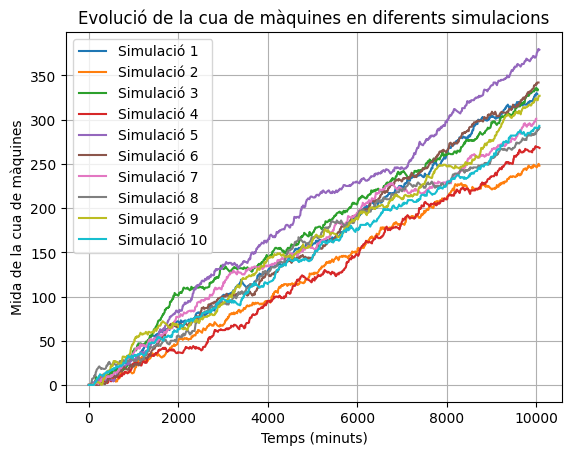

In [22]:
res = [simulacio(5,3) for _ in range(10)]

for i, r in enumerate(res):
    df = pd.DataFrame(r)  # convertir la llista de dicts en DataFrame
    plt.plot(df["temps"], df["cua_maquines"], label=f"Simulació {i+1}")

    # Calcular pesos com la diferència entre temps consecutius
    df["delta_temps"] = df["temps"].diff().shift(-1)  # el temps que dura cada observació
    df = df[:-1]  # eliminar l'última fila que té NaN a delta_temps

    # Mitjana ponderada: sum(cua * delta_t) / sum(delta_t)
    mitjana_ponderada = (df["cua_maquines"] * df["delta_temps"]).sum() / df["delta_temps"].sum()

    print(f"Simulació {i+1}: Llargària mitjana ponderada de la cua de tasques: {mitjana_ponderada:.2f}")


plt.xlabel("Temps (minuts)")
plt.ylabel("Mida de la cua de màquines")
plt.title("Evolució de la cua de màquines en diferents simulacions")
plt.legend()
plt.grid(True)
plt.show()

Per reduir la cua de tasques podriem incrementar el nombre màquines o el nombre d'operaris. Anem a veure què passaria si incrementem per 1 aquests dos valors

Simulació 1: Llargària mitjana ponderada de la cua de tasques: 96.55
Simulació 2: Llargària mitjana ponderada de la cua de tasques: 67.04
Simulació 3: Llargària mitjana ponderada de la cua de tasques: 87.77
Simulació 4: Llargària mitjana ponderada de la cua de tasques: 119.54
Simulació 5: Llargària mitjana ponderada de la cua de tasques: 62.64
Simulació 6: Llargària mitjana ponderada de la cua de tasques: 84.38
Simulació 7: Llargària mitjana ponderada de la cua de tasques: 79.33
Simulació 8: Llargària mitjana ponderada de la cua de tasques: 64.35
Simulació 9: Llargària mitjana ponderada de la cua de tasques: 101.98
Simulació 10: Llargària mitjana ponderada de la cua de tasques: 95.88


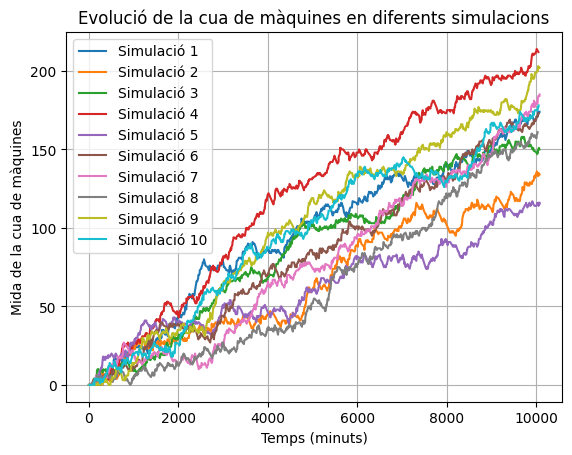

In [23]:
res = [simulacio(6,4) for _ in range(10)]

for i, r in enumerate(res):
    df = pd.DataFrame(r)  # convertir la llista de dicts en DataFrame
    plt.plot(df["temps"], df["cua_maquines"], label=f"Simulació {i+1}")

    # Calcular pesos com la diferència entre temps consecutius
    df["delta_temps"] = df["temps"].diff().shift(-1)  # el temps que dura cada observació
    df = df[:-1]  # eliminar l'última fila que té NaN a delta_temps

    # Mitjana ponderada: sum(cua * delta_t) / sum(delta_t)
    mitjana_ponderada = (df["cua_maquines"] * df["delta_temps"]).sum() / df["delta_temps"].sum()

    print(f"Simulació {i+1}: Llargària mitjana ponderada de la cua de tasques: {mitjana_ponderada:.2f}")


plt.xlabel("Temps (minuts)")
plt.ylabel("Mida de la cua de màquines")
plt.title("Evolució de la cua de màquines en diferents simulacions")
plt.legend()
plt.grid(True)
plt.show()

Obervem un gran canvi en el nombre d'elements a la cua

### Exercici 3

Analitza la següent cadena de Markov:
[<center><img src=https://raw.githubusercontent.com/gjover/modelitzacio/refs/heads/main/notebooks/static/markov.png width=25%></center>](#bib_Konstantopoulos)

- Escriu la matriu de transició
- És irreductible?
- És aperiòdica?
- Si comencem a l'estat 1, quina probabilitat n'hi ha que ens trobem a cada un dels estats deprés de 3 passes?
- Troba la distribució d'estats estable si existeix.

In [24]:
P = np.array([
    [1/2, 1/3, 1/6],
    [3/4, 0,   1/4],
    [0,   1,   0]
])
P

array([[0.5       , 0.33333333, 0.16666667],
       [0.75      , 0.        , 0.25      ],
       [0.        , 1.        , 0.        ]])

Una cadena de Markov és irreductible si qualsevol estat es pot assolir des de qualsevol altre estat (potser en més d’un pas). Això vol dir que tots els estats estan connectats en el sentit probabilístic. Verifiquem-ho:

In [25]:
import networkx as nx
from math import gcd
from functools import reduce

def is_irreducible(P):
    n = P.shape[0]
    G = nx.DiGraph()

    for i in range(n):
        for j in range(n):
            if P[i, j] > 0:
                G.add_edge(i, j)

    return nx.is_strongly_connected(G)

if is_irreducible(P):
    print("The Markov chain is irreducible.")
else:
    print("The Markov chain is not irreducible.")


The Markov chain is irreducible.


Es verifica. D'altra banda, és aperiòdica si els retorns a un estat poden passar en moments que no tenen un patró cíclic fix. Més formalment, un estat té període d si tots els camins que tornen a aquest estat tenen longitud múltiple de d. Si d = 1, l'estat és aperiòdic. Si tots els estats tenen període 1, la cadena és aperiodica. Anem-ho a veure:

In [26]:
def get_period(P, state):
    n = P.shape[0]
    max_power = 100
    periods = []

    reachable_times = []
    P_power = np.eye(n)

    for k in range(1, max_power+1):
        P_power = np.matmul(P_power, P)
        if P_power[state, state] > 1e-12:
            reachable_times.append(k)

    if not reachable_times:
        return None

    period = reduce(gcd, reachable_times)
    return period

def is_aperiodic(P):
    n = P.shape[0]
    for state in range(n):
        period = get_period(P, state)
        if period != 1:
            return False
    return True

if is_aperiodic(P):
  print("The Markov chain is aperiodic.")
else:
  print("The Markov chain is not aperiodic.")

The Markov chain is aperiodic.


També es verifica. Anem a calcular la probabilitat de trobar-nos en cada estat després de 3 passes començant a l'estat 1

In [27]:
probs0 = np.array([1, 0, 0])  # Comença en el primer estat (probabilitat 1)
probs3 = probs0 @ (P @ P @ P)
probs3

array([0.5       , 0.33333333, 0.16666667])

Anem a trobar la distribució d’estats estable. Haurem de buscar el vector $\pi=[\pi_1, \pi_2, \pi_3]$ tal que:
* $\pi P=\pi$
* $\pi_1+\pi_2+\pi_3=1$

In [28]:
pi1, pi2, pi3 = sp.symbols('pi1 pi2 pi3')

P = sp.Matrix([
    [1/2, 1/3, 1/6],
    [3/4, 0,   1/4],
    [0,   1,   0]
])

pi = sp.Matrix([[pi1, pi2, pi3]])

product = pi * P

# Sistema d’equacions
eqs = [
    sp.Eq(product[0, 0], pi1),
    sp.Eq(product[0, 1], pi2),
    sp.Eq(product[0, 2], pi3),
    sp.Eq(pi1 + pi2 + pi3, 1)
]

# Resolució
sol = sp.solve(eqs, [pi1, pi2, pi3], dict=True)
sp.pprint(sol)

[{π₁: 0.5, π₂: 0.333333333333333, π₃: 0.166666666666667}]


# Referències

- <a id='img_FaXToR'></a> Takis Konstantopoulos, **2019**. *Stochastic Processes I*

Copyright (C) 2022 Gabriel Jover Mañas

    Permission is granted to copy, distribute and/or modify this document
    under the terms of the GNU Free Documentation License, Version 1.3
    or any later version published by the Free Software Foundation;
    with no Invariant Sections, no Front-Cover Texts, and no Back-Cover Texts.
    A copy of the license is included in the section entitled "GNU
    Free Documentation License".

![GFDL][GFDL]

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.

![GPL3][GPL3]

[GFDL]: static/gfdl-logo-small.png
[GPL3]: static/gplv3-127x51.png